In [1]:
# compare the data from different years for cluster shape/position

import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, make_ratio_plot
import os
import CMS_lumi, tdrstyle
a = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2

# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [10]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()
ver = 'V1p17'
sig_ver = 'v151'


for year in ['16', '17', '18']:
    data_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ver+'/Data20'+year+'/v5/'+sig_ver+'/normalized/'
    if year == '16':fpath_bkg['data'+year] = data_path+"Run2_displacedJetMuonNtupler_V1p17_Data20"+year+"_Run20"+year+"-ZMu-07Aug17_goodLumi.root"
    elif year == '17':fpath_bkg['data'+year] = data_path+"Run2_displacedJetMuonNtupler_V1p17_Data20"+year+"_Run20"+year+"-ZMu-17Nov2017_goodLumi.root"
    else: fpath_bkg['data'+year] = data_path+"Run2_displacedJetMuonNtupler_V1p17_Data2018_17Sept2018_Run2018-ZMu-17Sep2018_goodLumi.root"
for k,v in fpath_bkg.items():
    print (k, v)
    root_dir = uproot.open(v) 
    tree_bkg[k] = root_dir['MuonSystem']
    a = tree_bkg[k]["weight"].array()
    print(a.shape)

data16 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2016/v5/v151/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016-ZMu-07Aug17_goodLumi.root
(286742,)
data17 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2017/v5/v151/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-ZMu-17Nov2017_goodLumi.root
(354744,)
data18 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2018/v5/v151/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2018_17Sept2018_Run2018-ZMu-17Sep2018_goodLumi.root
(501048,)


# DY MC mass comparision (no cluster requirement)

In [15]:
%%time

jetPt_cut = 50
tightid = False
ZPt = {}
ZMass = {}
lepPt = {}
lepEta = {}
lepE = {}
lepE_tag = {}
lepEta_tag = {}
lepPt_tag = {}
rho = {}
npu = {}
npv = {}
tag_index = {}
probe_index = {}
lepOverallSF = {}
sel_lep = {}
sel_ev = {}
sel_tp = {}
lepSF = {}
muonPt = 50
norm = 50
tag_probe = True
masses = [('120','800')]
for (m1,m2) in masses:
    for k, T in tree_bkg.items():
    # ########### BRANCHES ############
        sel_lep[k] = np.logical_and(T.array('lepPassId')==1, T.array("lepPassTightIso")==1) #tight iso+id lepton
        sel_lep[k] = np.logical_and(sel_lep[k], np.abs(T.array("lepPdgId"))==13) #tight iso+id lepton
        sel_ev[k] = sel_lep[k].sum()>=1

        sel_ev[k] = np.logical_and(sel_ev[k], (T.array('lepPt')>= muonPt).sum()==2)
        sel_ev[k] = np.logical_and(sel_ev[k], T.array('category')==2)
        sel_ev[k] = np.logical_and(sel_ev[k], T['HLTDecision'].array()[:,136])
        print(k,np.count_nonzero(sel_ev[k]))
        if k[:2] == 'dy':sel_ev[k] = np.logical_and(sel_ev[k], T.array('lepFromZ').sum()==2)
        print(k,np.count_nonzero(sel_ev[k]))


        if m1 == '50':
            sel_ev[k] = np.logical_and(sel_ev[k], T.array('ZMass')>=int(60))
        else:
            sel_ev[k] = np.logical_and(sel_ev[k], T.array('ZMass')>=int(m1))
        sel_ev[k] = np.logical_and(sel_ev[k], T.array('ZMass')<int(m2))
        probe_index[k] = []
        sel_tp[k] = []
        index = 0
        for i, ev in enumerate(sel_ev[k]):
            if ev:
                if sel_lep[k][i][0]:
                    probe_index[k].append([False,True])
                    sel_tp[k].append(index)
                if sel_lep[k][i][1]:
                    probe_index[k].append([True, False])
                    sel_tp[k].append(index)
                index+=1
        sel_tp[k] = np.array(sel_tp[k])
        probe_index[k] = np.array(probe_index[k])
        
        ZMass[k]= T.array('ZMass')[sel_ev[k]][sel_tp[k]]
        ZPt[k] = T.array('ZPt')[sel_ev[k]][sel_tp[k]]
        rho[k]= T.array('rho')[sel_ev[k]][sel_tp[k]]
        npv[k]= T.array('npv')[sel_ev[k]][sel_tp[k]]
        npu[k]= T.array('npu')[sel_ev[k]][sel_tp[k]]

       
        lepE[k] = np.array(T.array('lepE')[sel_ev[k]][sel_tp[k]])[probe_index[k]]
        lepEta[k] = np.array(T.array('lepEta')[sel_ev[k]][sel_tp[k]])[probe_index[k]]
        lepPt[k] = np.array(T.array('lepPt')[sel_ev[k]][sel_tp[k]])[probe_index[k]]
        if k[:2] == 'dy': lepSF[k] = np.array(T.array('lepSF')[sel_ev[k]][sel_tp[k]])[probe_index[k]]


        lepE[k] = np.array(lepE[k])
        lepEta[k] = np.array(lepEta[k])
        lepPt[k] = np.array(lepPt[k])
        if k[:2] == 'dy':lepSF[k] = np.array(lepSF[k])
        if '16' in k:lumi = 35920
        elif '17' in k:lumi = 41530
        elif '18' in k: lumi = 59740
        print(k, np.count_nonzero(sel_ev[k]), np.count_nonzero(sel_ev[k])/lumi)


data16 282648
data16 282648
data16 282170 7.8555122494432075
data17 352973
data17 352973
data17 352310 8.483265109559355
data18 498671
data18 498671
data18 497738 8.331737529293605
CPU times: user 29 s, sys: 1.08 s, total: 30.1 s
Wall time: 29.5 s


/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/simulation_modelling/2017_norm50_V1p17v148
672506 672506
data 672506.0 672506.0
274165 274165
dy_120_800 674791.8206850078 674791.9
ZMass 0.9966125542501576


Warning in <TROOT::Append>: Replacing existing TH1: dy_120_800 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/simulation_modelling/2017_norm50_V1p17v148_tag_probe/ZMass_Zmass120_800_muon50_norm50.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/simulation_modelling/2017_norm50_V1p17v148_tag_probe/ZMass_Zmass120_800_muon50_norm50.C has been generated
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/simulation_modelling/2017_norm50_V1p17v148_tag_probe/ZMass_Zmass120_800_muon50_norm50_log.png has been created
Info in <

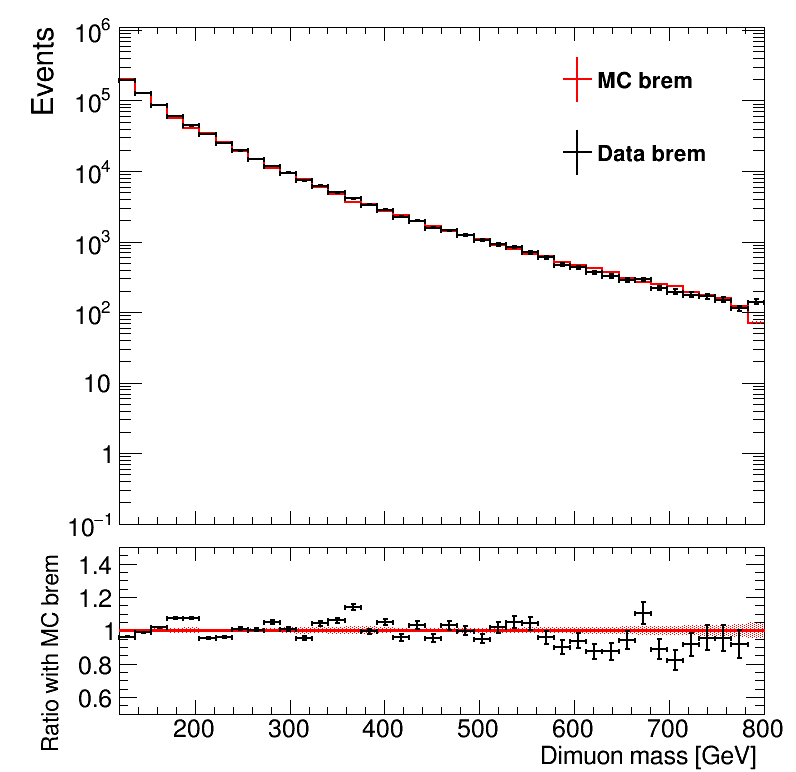

In [67]:
############ PLOTTING #########
import os
h = {}

var = [ZMass, ZMass, ZPt, lepPt, lepE, lepEta]
title = ['Dimuon mass [GeV]','Dimuon mass [GeV]', 'Z p_{T} [GeV]', 'muon pT [GeV]', 'muon E [GeV]', 'muon #eta']

bins = [ [40,int(m1),int(m2)],[25,50,120],  list(np.arange(0,300,25))+[300, 350, 400,500,800], list(np.arange(0,300,25))+[300, 350, 400,500,800], list(np.arange(0,500,50))+[500,575, 650, 725,800,900,1000]+[1200, 1600, 2000], [20,0.0,2.5],]
# bins = [ [40,int(m1),int(m2)],[25,50,120], list(np.arange(0,300,25))+[300, 350, 400,500,800], [50,0,2000], [20,0.0,2.5],]


reweight = False

names = ['ZMass', 'ZMass50_120','ZPt', 'cscRechitCluster2IsoMuonVetoPt', 'cscRechitCluster2IsoMuonVetoE', 'cscRechitCluster2IsoMuonVetoEta']
assert(len(var) == len(title) == len(names) == len(bins) )
dir_name = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/simulation_modelling/'+year+\
'_norm'+str(norm)+'_'+ver+sig_ver
print(dir_name)
if tag_probe: dir_name+="_tag_probe"
dir_name += '/'
if not os.path.isdir(dir_name):os.makedirs(dir_name)
keys = ['data', 'dy_'+m1+'_'+m2]
for j, v in enumerate(var):
    if int(m1) >= 120 and j == 1:continue
    if not j == 0:continue
    for i,k in enumerate(keys):
        if k[:2] == 'dy': total_weight = weight[k]*lepOverallSF[k]*pileupWeight[k]*mc_corr_weight[k]
        else: total_weight = weight[k]
        print(len(total_weight), len(var[j][k]))
        if reweight:
            h_reweight = {}
            h_reweight['mc_reweight'] = create_TH1D( np.abs(ZPt[k]), axis_title=['ZPt', 'Events'], name=k, binning=bins[2], weights = total_weight)
            h_reweight['data_reweight'] = create_TH1D( np.abs(ZPt['data']), axis_title=['ZPt', 'Events'], name='data', binning=bins[2], weights = weight['data']*pileupWeight['data']*mc_corr_weight['data'])
            h_reweight['data_reweight'].Divide(h_reweight['mc_reweight'])
            reweight = []
            for m in range(len(ZPt[k])):
                reweight.append(h_reweight['data_reweight'].GetBinContent(h_reweight['data_reweight'].GetXaxis().FindFixBin(np.abs(ZPt[k])[m])))
            total_weight *= reweight
        cond = ZMass[k]>=0
        h[k] = create_TH1D( np.abs(var[j][k][cond].flatten()), axis_title=[title[j], 'Events'], name=k, binning=bins[j], weights = total_weight[cond])

        print(k, h[k].Integral(), np.sum(total_weight))

        h[k].SetLineColor(std_color_list[i])
    print(names[j], h[keys[0]].Integral()*1.0/h[keys[1]].Integral())


    c = make_ratio_plot([h[keys[1]],h[keys[0]]], fit = False, logy=False, in_tags = ["MC brem","Data brem"], ratio_bounds = [0.5,1.5], draw_opt = ['E2','E1']) 
    c.Draw()
    if reweight:
        c.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_ZptReweight.png')
        c.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_ZptReweight.C')
    else:
        c.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'.png')
        c.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'.C')
    c_log = make_ratio_plot([h[keys[1]],h[keys[0]]], fit = False, logy=True, in_tags = ["MC brem","Data brem"], ratio_bounds = [0.5,1.5], draw_opt = ['E2','E1']) 
    c_log.Draw()
    if reweight:
        c_log.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_ZptReweight_log.png')
        c_log.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_ZptReweight_log.C')
    else:
        c_log.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_log.png')
        c_log.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_log.C')
# for i in range(74):
#     print(i+1, h[keys[0]].GetBinCenter(i+1), h[keys[0]].GetBinContent(i+1)/h[keys[1]].GetBinContent(i+1))


# cluster level variables (matched to probe muon, all mass bins)

In [16]:
%%time

sel_tp = {}
clusterSize = {}
clusterEta = {}
clusterTimeSpread = {}
clusterTimeTotal = {}
clusterMe11Ratio = {}
clusterMB1Ratio = {}
clusterMatchMB1 = {}
clusterMatchRPC = {}
sel_lep = {}
sel_ev = {}
cut_based = {}
probe_index = {}
sel_tp = {}
cond = {}
cscRechitClusterMaxChamber = {}
ZMass = {}
lepEta = {}
muonPt = 50
tag_probe = True
norm = False
text = False
scaling = 'norm'
region = 'csc'
for k, T in tree_bkg.items():
    sel_cluster = np.abs(T.array(region+ 'RechitClusterSize'))>=50
    sel_cluster = np.logical_and(sel_cluster, np.logical_or(T.array(region+ 'RechitClusterZLep1') == 1, T.array(region+ 'RechitClusterZLep2') == 1))
    if tag_probe: 
        sel_cluster1 =np.logical_and(sel_cluster,  T.array(region+ 'RechitClusterZLep1') == 1)   #loose lepton
        sel_cluster2 = np.logical_and(sel_cluster,  T.array(region+ 'RechitClusterZLep2') == 1)  

# ########### BRANCHES ############
    sel_lep[k] = np.logical_and(T.array('lepPassId')==1, T.array("lepPassTightIso")==1) #tight iso+id lepton
    sel_lep[k] = np.logical_and(sel_lep[k], np.abs(T.array("lepPdgId"))==13) #tight iso+id lepton
    sel_ev[k] = sel_lep[k].sum()>=1
    sel_ev[k] = np.logical_and(sel_ev[k], (T.array('lepPt')>= muonPt).sum()==2)
    sel_ev[k] = np.logical_and(sel_ev[k], T.array("Flag2_all"))
    sel_ev[k] = np.logical_and(sel_ev[k], T.array('category')==2)
    sel_ev[k] = np.logical_and(sel_ev[k], T['HLTDecision'].array()[:,136])

    sel_ev[k] = np.logical_and(sel_ev[k], T.array('ZMass')>=120)
    sel_ev[k] = np.logical_and(sel_ev[k], T.array('ZMass')<800)
    probe_index[k] = []
    sel_tp[k] = []
    cond[k] = []
    sel_probecluster = []
    pdgid = T.array("lepPdgId")


    index = 0
    for i, ev in enumerate(sel_ev[k]):
        if ev:
            if sel_lep[k][i][0]:
                probe_index[k].append([False,True])
                sel_tp[k].append(index)
                if pdgid[i][0] == 13:
                    cond[k].append(np.logical_and(sel_cluster2[i].sum()==1, sel_cluster1[i].sum()==0))
                    if cond[k][-1]: sel_probecluster.append(sel_cluster2[i])
                else:
                    cond[k].append(np.logical_and(sel_cluster1[i].sum()==1, sel_cluster2[i].sum()==0)) 
                    if cond[k][-1]:sel_probecluster.append(sel_cluster1[i])
            if sel_lep[k][i][1]:
                probe_index[k].append([True, False])
                sel_tp[k].append(index)
                if pdgid[i][0] == -13:
                    cond[k].append(np.logical_and(sel_cluster2[i].sum()==1, sel_cluster1[i].sum()==0))
                    if cond[k][-1]:sel_probecluster.append(sel_cluster2[i])
                else:
                    cond[k].append(np.logical_and(sel_cluster1[i].sum()==1, sel_cluster2[i].sum()==0)) 
                    if cond[k][-1]:sel_probecluster.append(sel_cluster1[i])
            index+=1
    sel_tp[k] = np.array(sel_tp[k])
    probe_index[k] = np.array(probe_index[k])

    cond[k] = np.array(cond[k])
    sel_probecluster = awkward.fromiter(sel_probecluster)

    clusterSize[k] = awkward.fromiter(T.array(region+ 'RechitClusterSize')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
    if region == 'csc':
        clusterTimeSpread[k] = awkward.fromiter(T.array('cscRechitClusterTimeSpread')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        clusterTimeTotal[k] = awkward.fromiter(T.array('cscRechitClusterTimeTotal')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        clusterMe11Ratio[k] = awkward.fromiter(T.array('cscRechitClusterMe11Ratio')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
    else:
        clusterMB1Ratio[k] = awkward.fromiter((T.array('dtRechitClusterNSegmentStation1')/T.array('dtRechitClusterSize'))[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        clusterMatchRPC[k] = awkward.fromiter(T.array('dtRechitCluster_match_RPChits_dPhi0p5')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        clusterMatchMB1[k] = awkward.fromiter(T.array('dtRechitCluster_match_MB1hits_0p5')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]

    clusterEta[k] = awkward.fromiter(T.array(region+ 'RechitClusterEta')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
#     clusterMaxChamber[k] = awkward.fromiter(T.array('cscRechitClusterMaxChamber')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]

    print(k)


data16
data17
data18
CPU times: user 1min 31s, sys: 1.24 s, total: 1min 32s
Wall time: 1min 32s


# cluster 

/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/DataYear_shape_comparison_SingleMuon_muonShower_norm_V1p17v151_tag_probe/
6 6 6 6
data16 clusterTimeTotal efficiency 0.9914935707220573 0.0012881950470351455 0.0014975544977772204
data17 clusterTimeTotal efficiency 0.993038493038493 0.0009690922881974151 0.0011131592067601392
data18 clusterTimeTotal efficiency 0.9916826003824092 0.0008870443786225257 0.000986121887632252
/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/DataYear_shape_comparison_SingleMuon_muonShower_norm_V1p17v151_tag_probe/csc_clusterTimeTotal_withRatio_muonPt50_120_800


Warning in <TROOT::Append>: Replacing existing TH1: data16 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data16 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data17 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data17 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data18 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data18 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/DataYear_shape_comparison_SingleMuon_muonShower_norm_V1p17v151_tag_probe/csc_clusterTimeTotal_withRatio_muonPt50_120_800_norm.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analys

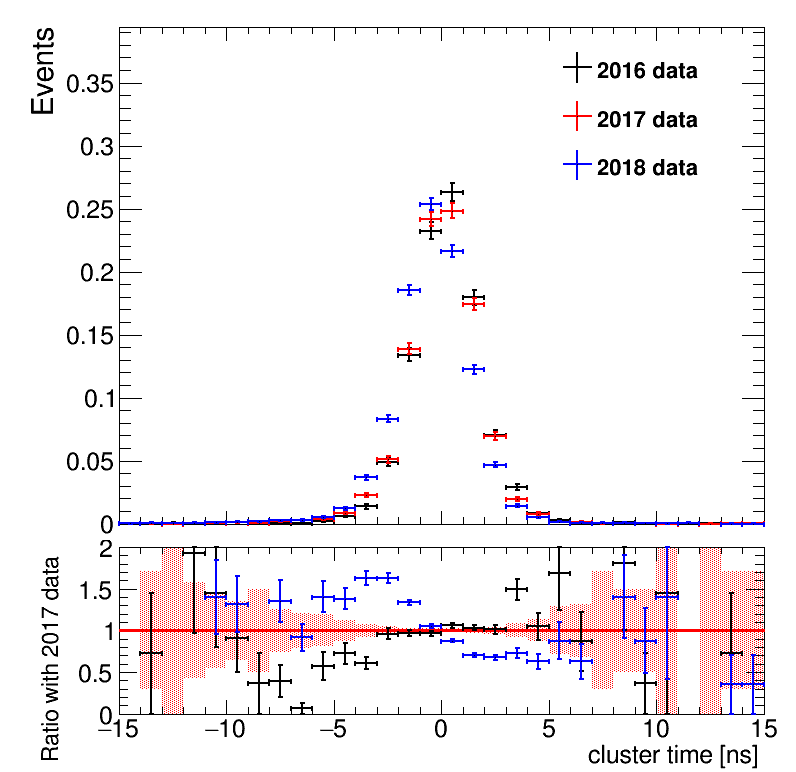

In [36]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff


rt.gStyle.SetOptFit(1011)
dir_name = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/DataYear_shape_comparison_SingleMuon_muonShower_'+scaling+'_'+ver+sig_ver
if tag_probe: dir_name+="_tag_probe"
dir_name += '/'

if not os.path.isdir(dir_name):os.makedirs(dir_name)
print(dir_name)
if region == 'dt': Nrechits_cut = 80
else: Nrechits_cut = 100

var = [clusterSize, clusterTimeTotal, clusterTimeSpread,clusterMe11Ratio, clusterMB1Ratio, clusterMatchRPC]
names = ['clusterSize', 'clusterTimeTotal', 'clusterTimeSpread','clusterMe11Ratio', 'clusterMB1Ratio', 'clusterMatchRPC']
title = ['N_{rechits}',  'cluster time [ns]','cluster strip time spread [ns]', 'ME11 ratio', 'MB1 ratio', 'clusterMatchRPC']

bins = [ [0, 50, 70, 100, 150, 250, 500], [30,-15,15],  list(np.arange(0,20,2))+list(np.arange(20,35,5))+[50],[20,0,1.0],[20,0,1],[50,0,50]]


print(len(var) , len(title) , len(names) , len(bins))
assert(len(var) == len(title) == len(names) == len(bins))
norm = 1
fit = 1
key_plot = ['data16', 'data17', 'data18']
for j,v in enumerate(var):
    if region == 'csc' and j >= 4:continue
    if region == 'dt' and j > 0 and j <= 3:continue
        
    if not j == 1:continue

    h = {}
    h_ks = {}
    maximum = 0
    for i,k in enumerate(key_plot):
        if region == 'csc':
            selections = [
            clusterSize[k]>=Nrechits_cut,
            np.logical_and(clusterTimeTotal[k]<5, clusterTimeTotal[k]>-12.5),
            clusterTimeSpread[k]<20,
            clusterMe11Ratio[k]<1,
            clusterSize[k]>=0,
            clusterSize[k]>=0,
            ]
        else:
            selections = [
            clusterSize[k]>=Nrechits_cut,
            clusterSize[k]>=0,
            clusterSize[k]>=0,
            clusterSize[k]>=0,
#             clusterMatchMB1[k]<=1,
            clusterMB1Ratio[k]<0.9,
            clusterMatchRPC[k] >= 0,
            ]
        sel = clusterSize[k]>=0
        for l, s in enumerate(selections):
            if l == j:continue
            sel = np.logical_and(sel, s)


        h[k] = create_TH1D( v[k][sel], axis_title=[title[j], 'Events'], name=k, binning=bins[j])
        if norm: h[k].Scale(1./h[k].Integral())
        h[k].SetLineColor(std_color_list[i])

        new_cond = selections[j][sel]
        
        if j < 0:
            if region == 'csc':eta_cut = np.abs(lepEta[k])>0.9
            else: eta_cut = np.abs(lepEta[k])<1.2
#             eta_cut = np.abs(lepEta[k])>=0
            if 'dy' in k:
                for cut in Nrechits_cut+np.arange(10):
                    temp = np.logical_and(new_cond, clusterSize[k][sel]>=cut)
                    hm = create_TH1D( np.ones((np.count_nonzero(temp),)), name=k, binning=[1,0,2])
#                     hm = create_TH1D( np.ones((np.count_nonzero(new_cond),)), name=k, binning=[1,0,2], weights = total_weight[sel][new_cond])
                    hb = create_TH1D( np.ones((len(weight[k][eta_cut]),)), name=k, binning=[1,0,2])
                    eff = rt.TEfficiency(hm,hb)
                    print(k, cut, names[j]+' efficiency', eff.GetEfficiency(1),eff.GetEfficiencyErrorUp(1),eff.GetEfficiencyErrorLow(1))#             new_cond = 
            else:
#                 hm = create_TH1D( np.ones((np.count_nonzero(clusterSize[k]>=Nrechits_cut),)), name=k, binning=[1,0,2], weights = total_weight[clusterSize[k]>=Nrechits_cut])
                hm = create_TH1D( np.ones((np.count_nonzero(new_cond),)), name=k, binning=[1,0,2])
                hb = create_TH1D( np.ones((len(weight[k][eta_cut]),)), name=k, binning=[1,0,2])
                eff = rt.TEfficiency(hm,hb)
                print(k, names[j]+' efficiency', eff.GetEfficiency(1),eff.GetEfficiencyErrorUp(1),eff.GetEfficiencyErrorLow(1))#             new_cond =     
        else:
            hm = create_TH1D( np.ones((np.count_nonzero(new_cond),)), name=k, binning=[1,0,2])
            hb = create_TH1D( np.ones((len(v[k][sel]),)), name=k, binning=[1,0,2])
            eff = rt.TEfficiency(hm,hb)
            print(k, names[j]+' efficiency', eff.GetEfficiency(1),eff.GetEfficiencyErrorUp(1),eff.GetEfficiencyErrorLow(1))
            
#             if j == 1 and fit:
#                 r = h[k].Fit('gaus')
#                 print(r)
#     print(h[key_plot[1]].Integral(), h[key_plot[0]].Integral())
    c = make_ratio_plot([h['data16'], h['data17'], h['data18']], fit = False, logy=False, in_tags = ["2016 data", "2017 data", "2018 data"], ratio_bounds = [0.0,2], \
                ratio_index = 1, draw_opt = ['E1','E1','E1']) 
        
    
    
    c.Draw()

    file_name = dir_name+region+'_'+names[j]+"_withRatio_muonPt"+str(muonPt)+"_"+m1+'_'+m2
    print(file_name)
    if norm: file_name += "_norm"
    c.SaveAs(file_name+".png")
    c.SaveAs(file_name+".C")


In [161]:
np.count_nonzero(clusterMB1Ratio[k]<0.9)

19402